# 本筆記拿鐵達尼號資料集來練習建模。



我們將用Scikit-learn和Keras來建立一些基本的模型。

* [將檔案存為Pandas DataFrame](#%E5%B0%87%E6%AA%94%E6%A1%88%E5%AD%98%E7%82%BAPandas-DataFrame)

* [空直填補](#%E7%A9%BA%E7%9B%B4%E5%A1%AB%E8%A3%9C)

* [用scikit-learn建立模型：Decision Tree](#%E7%94%A8scikit-learn%E5%BB%BA%E7%AB%8B%E6%A8%A1%E5%9E%8B%EF%BC%9ADecision-Tree)

* [用scikit-learn建立模型：Random Forest](#%E7%94%A8scikit-learn%E5%BB%BA%E7%AB%8B%E6%A8%A1%E5%9E%8B%EF%BC%9ARandom-Forest)
* [scikit-learn練習：使用logistic regression來分資料，並輸出分類報告](#scikit-learn%E7%B7%B4%E7%BF%92%EF%BC%9A%E4%BD%BF%E7%94%A8logistic-regression%E4%BE%86%E5%88%86%E8%B3%87%E6%96%99%EF%BC%8C%E4%B8%A6%E8%BC%B8%E5%87%BA%E5%88%86%E9%A1%9E%E5%A0%B1%E5%91%8A%E3%80%82)
* [用Keras建立模型：Logistic Regression](#%E7%94%A8Keras%E5%BB%BA%E7%AB%8B%E6%A8%A1%E5%9E%8B%EF%BC%9ALogistic-Regression)
* [用Keras建立模型：Multilayer Perceptron + BatchNorm](#%E7%94%A8Keras%E5%BB%BA%E7%AB%8B%E6%A8%A1%E5%9E%8B%EF%BC%9AMultilayer-Perceptron)
* [用Keras建立模型：Multilayer Perceptron + Dropout](#%E7%94%A8Keras%E5%BB%BA%E7%AB%8B%E6%A8%A1%E5%9E%8B%EF%BC%9AMultilayer-Perceptron-+-Dropout)

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np
import re

In [2]:
# Here's a temporary workout. I replace data in several dataframes, which leads to some warning messages
import warnings
warnings.filterwarnings("ignore")

### 將檔案存為Pandas DataFrame

In [3]:
data=pd.read_csv("../datasets/titanic/titanic_train.csv") # 輸入資料

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


[回到頂部](#%E6%9C%AC%E7%AD%86%E8%A8%98%E6%8B%BF%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E8%B3%87%E6%96%99%E9%9B%86%E4%BE%86%E7%B7%B4%E7%BF%92%E5%BB%BA%E6%A8%A1%E3%80%82)

---

### 空直填補

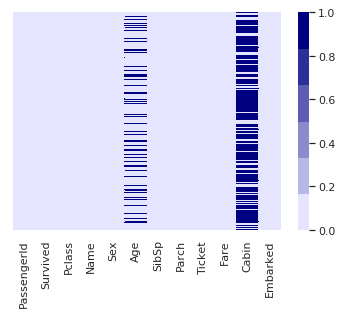

In [5]:
cmap=sns.light_palette("navy", reverse=False)
sns.heatmap(data.isnull().astype(np.int8),yticklabels=False,cmap=cmap)

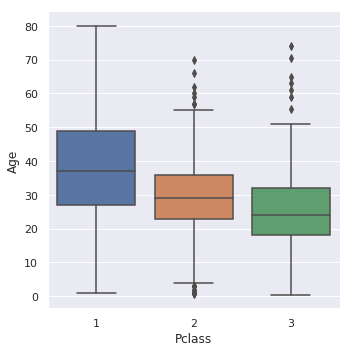

In [6]:
g=sns.factorplot(x="Pclass",y="Age",data=data,kind="box")

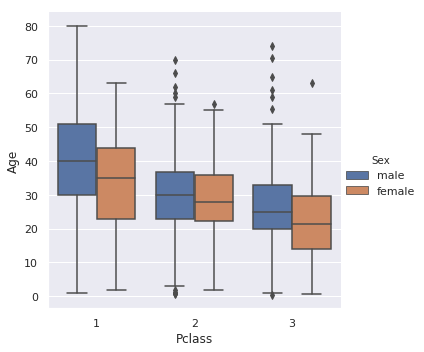

In [7]:
g=sns.factorplot(x="Pclass",y="Age",hue="Sex",data=data,kind="box")

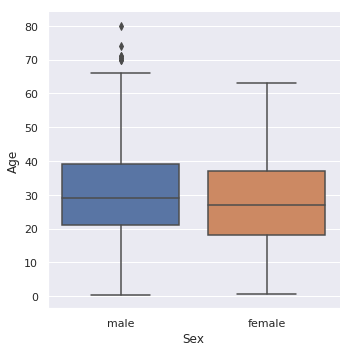

In [8]:
g=sns.factorplot(x="Sex",y="Age",data=data,kind="box")

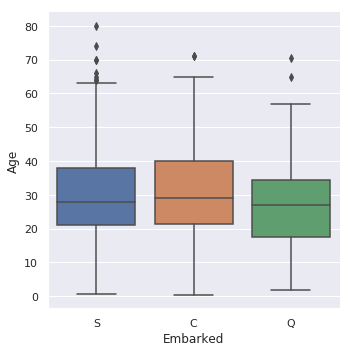

In [9]:
g=sns.factorplot(x="Embarked",y="Age",data=data,kind="box")

決定用Pclass的中位數來填補Age之空值。

In [10]:
data.groupby("Pclass").median()["Age"]

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [11]:
def dataClean(df):
    # 資料整理。將空值填補。
    
    nanIndexes={}
    groups=df.groupby("Pclass")
    for name,group in groups:
        nanIndexes[name]=group["Age"][group["Age"].isnull()].index
    data["Age"][nanIndexes[1]]=37
    data["Age"][nanIndexes[2]]=29
    data["Age"][nanIndexes[3]]=24
    
    idxEmbarked=df[df["Embarked"].isnull()].index
    idxDrop=idxEmbarked
    df=df.drop(index=idxDrop)

    df=df.drop(
        columns=["Name","PassengerId","Cabin","Ticket"])

    df["famSize"]=df["SibSp"]+df["Parch"]
    df["Kid"]=df["Age"].apply(lambda x: 1 if x<12 else 0)
    df["Pclass"]=df["Pclass"].astype("object")
    df["Sex"]=df["Sex"].apply(lambda x:0 if "female" in x else 1)
    
    for col in ["Age","Fare"]:
        df[col]=( df[col]-df[col].mean() ) / df[col].std()
    
    df=pd.get_dummies(df)
    
    print("檢查資料整理前是否存在空值:\n",df.isnull().sum(),"\n") # 檢查空值情形。
    return df

def trainTestValSplit(df):
    # 將資料切分為訓練(70%),測試(15%)和驗證(15%)三份。
    train=df.sample(frac=0.7)
    test=df.drop( train.index )
    val=test.sample(frac=0.5)
    test=test.drop( val.index)
    return train,test,val

def dfXYSplit(df,targetName):
    # 將特徵和目標變數切成兩份資料。
    
    dfX=df.drop(columns=targetName)
    dfY=df[targetName]
    
    return dfX,dfY

In [12]:
data=pd.read_csv("../datasets/titanic/titanic_train.csv") # 輸入資料
data=dataClean(data)
print(data.info() )
data.head(5)

train,test,val=trainTestValSplit(data)

trainX,trainY=dfXYSplit(train,"Survived")
testX,testY=dfXYSplit(test,"Survived")
valX,valY=dfXYSplit(val,"Survived")

檢查資料整理前是否存在空值:
 Survived      0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
famSize       0
Kid           0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 14 columns):
Survived      889 non-null int64
Sex           889 non-null int64
Age           889 non-null float64
SibSp         889 non-null int64
Parch         889 non-null int64
Fare          889 non-null float64
famSize       889 non-null int64
Kid           889 non-null int64
Pclass_1      889 non-null uint8
Pclass_2      889 non-null uint8
Pclass_3      889 non-null uint8
Embarked_C    889 non-null uint8
Embarked_Q    889 non-null uint8
Embarked_S    889 non-null uint8
dtypes: float64(2), int64(6), uint8(6)
memory usage: 67.7 KB
None


資料整理完畢，可以開始建立模型。

[回到頂部](#%E6%9C%AC%E7%AD%86%E8%A8%98%E6%8B%BF%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E8%B3%87%E6%96%99%E9%9B%86%E4%BE%86%E7%B7%B4%E7%BF%92%E5%BB%BA%E6%A8%A1%E3%80%82)

---

### 用scikit-learn建立模型：Decision Tree

* Decision Tree: http://scikit-learn.org/stable/modules/tree.html#mathematical-formulation

In [13]:
from sklearn import tree
from sklearn.metrics import classification_report

In [14]:
clf=tree.DecisionTreeClassifier()
model=clf.fit(trainX,trainY)

testPredY=model.predict(testX)
valPredY=model.predict(valX)

print( classification_report(testY,testPredY) )
print( classification_report(valY,valPredY) )

             precision    recall  f1-score   support

          0       0.85      0.86      0.85        85
          1       0.74      0.73      0.74        48

avg / total       0.81      0.81      0.81       133

             precision    recall  f1-score   support

          0       0.82      0.85      0.84        87
          1       0.70      0.66      0.68        47

avg / total       0.78      0.78      0.78       134



In [15]:
tree.DecisionTreeClassifier()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble.forest import RandomForestClassifier

[回到頂部](#%E6%9C%AC%E7%AD%86%E8%A8%98%E6%8B%BF%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E8%B3%87%E6%96%99%E9%9B%86%E4%BE%86%E7%B7%B4%E7%BF%92%E5%BB%BA%E6%A8%A1%E3%80%82)

### 用scikit-learn建立模型：Random Forest

* Random Forest: https://www.youtube.com/watch?v=3kYujfDgmNk

* ```bootstrap=True``` ->要抽樣本
* ```n_jobs=1``` ->記得要改 ```n_jobs=-1```, 使用所有的CPU核心
* ```oob_score``` -> out of bag score
(bool (default=False))

In [17]:
clf = RandomForestClassifier()
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
model=clf.fit(trainX,trainY)

testPredY=model.predict(testX)
valPredY=model.predict(valX)

print( classification_report(testY,testPredY) )
print( classification_report(valY,valPredY) )

             precision    recall  f1-score   support

          0       0.89      0.88      0.89        85
          1       0.80      0.81      0.80        48

avg / total       0.86      0.86      0.86       133

             precision    recall  f1-score   support

          0       0.83      0.85      0.84        87
          1       0.71      0.68      0.70        47

avg / total       0.79      0.79      0.79       134



上面是錯的.不要把資料切三分丟給random forest.

Q: 什麼是OOB score?   
只把樣本丟不在訓練時給定樣本的模型

因為做隨機森林,驗證資料(validation data)不需要存在,故我們把驗證資料和訓練資料合併.

In [19]:
trainXNew = np.concatenate([trainX,valX],axis=0)
trainYNew = np.concatenate([trainY,valY],axis=0)

驗證資料有沒有合併成功:

In [20]:
assert valX.shape[0]+trainX.shape[0] == trainXNew.shape[0]
assert valY.shape[0]+trainY.shape[0] == trainYNew.shape[0]

In [21]:
clf = RandomForestClassifier(oob_score=True)
model=clf.fit(trainX,trainY)

In [22]:
model.oob_score_

0.7604501607717041

### scikit-learn練習：使用logistic regression來分資料，並輸出分類報告。

In [23]:
# # 補足以下程式碼
# from sklearn.linear_model.... import LogisticRegression
# clf=LogisticRegression()
# ...

SyntaxError: invalid syntax (<ipython-input-23-39c7a0c57dac>, line 2)

[回到頂部](#%E6%9C%AC%E7%AD%86%E8%A8%98%E6%8B%BF%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E8%B3%87%E6%96%99%E9%9B%86%E4%BE%86%E7%B7%B4%E7%BF%92%E5%BB%BA%E6%A8%A1%E3%80%82)

---

### 用Keras建立模型：Logistic Regression

In [24]:
from keras.models import Sequential
from keras.layers import Activation,Dense,Dropout,BatchNormalization
from keras.optimizers import RMSprop,SGD

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
Train on 622 samples, validate on 134 samples
Epoch 1/20
622/622 [==============================] - 2s 2ms/step - loss: 0.7370 - acc: 0.6061 - val_loss: 0.6465 - val_acc: 0.6343
Epoch 2/20
622/622 [==============================] - 0s 119us/step - loss: 0.6225 - acc: 0.6656 - val_loss: 0.5915 - val_acc: 0.6642
Epoch 3/20
622/622 [==============================] - 0s 114us/step - loss: 0.5964 - acc: 0.6768 - val_loss: 0.5682 - val_acc: 0.6567
Epoch 4/20
622/622 [==============================] - 0s 125us/step - loss: 0.5817 - acc: 0.6849 - val_loss: 0.5508 - val_acc: 0.7015
Epoch 5/20
622/622 [==============================] - 0s 112us/step - loss: 0.5702 - acc: 0.70

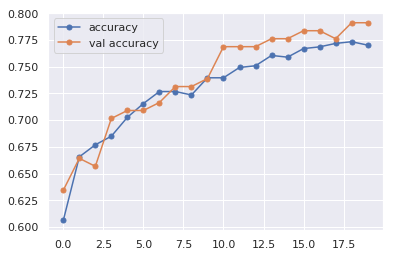

In [25]:
model=Sequential()

model.add(Dense(1, input_shape=(trainX.shape[1],),activation='sigmoid') ) 
# initiate RMSprop optimizer
#opt = RMSprop(lr=0.05, decay=1e-6)
opt = SGD(lr=0.05)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

history=model.fit(trainX.values,trainY.values,epochs=20, validation_data=( valX.values, valY.values ) )

#畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回到頂部](#%E6%9C%AC%E7%AD%86%E8%A8%98%E6%8B%BF%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E8%B3%87%E6%96%99%E9%9B%86%E4%BE%86%E7%B7%B4%E7%BF%92%E5%BB%BA%E6%A8%A1%E3%80%82)

### 用Keras建立模型：Multilayer Perceptron + BatchNorm

* Reference: 

  Rmsprop: http://ruder.io/optimizing-gradient-descent/

  簡單來說，是Gradient Descent的改良。相較於Gradient Descent是針對每一個網路參數($w_1,w_2,...,w_n$)使用相同的learning rate ($lr$)，RMSPROP則是能夠使得每一個每一個參數($w_1,w_2,...,w_n$)去擁有不同的learning rate ($lr_1, lr_2,...,lr_n$)。

* Reference: 

  BatchNormalization: https://zh-tw.coursera.org/learn/deep-neural-network/lecture/81oTm/why-does-batch-norm-work

  簡單來說，網路較內層的參數若於學習過程中一直改變，會導致較外層的輸出分佈一直產生變化。這件事情將不利於網路的訓練。我們若將這個分佈重新shift, 就可以加速網路訓練。(若看不懂這幾句話，請見以上連結，裡面有比較詳細的說明。)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                700       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total para

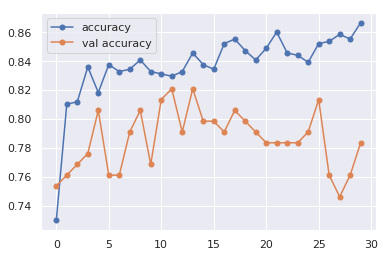

In [26]:
batch_size=32

model=Sequential()

model.add(Dense(50, input_shape=(trainX.shape[1],),activation='relu') )
model.add(BatchNormalization())
model.add(Activation("relu"))
# model.add(Dropout(0.5))

model.add(Dense(50) )
model.add(BatchNormalization())
model.add(Activation("relu"))
# model.add(Dropout(0.5))

model.add(Dense(1, input_shape=(trainX.shape[1],),activation='sigmoid') ) 
# initiate RMSprop optimizer
opt = RMSprop(lr=0.01, decay=1e-5)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

history=model.fit(trainX.values,trainY.values,epochs=30,
                  validation_data=( valX.values, valY.values ), batch_size=batch_size,verbose=1)

#畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回到頂部](#%E6%9C%AC%E7%AD%86%E8%A8%98%E6%8B%BF%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E8%B3%87%E6%96%99%E9%9B%86%E4%BE%86%E7%B7%B4%E7%BF%92%E5%BB%BA%E6%A8%A1%E3%80%82)

### 用Keras建立模型：Multilayer Perceptron + Dropout 

添加Dropout layer可減少Overfitting。

* Dropout layer: https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/dropout_layer.html

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                700       
_________________________________________________________________
batch_normalization_3 (Batch (None, 50)                200       
_________________________________________________________________
activation_3 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_4 (Batch (None, 50)                200       
_________________________________________________________________
activation_4 (Activation)    (None, 50)                0         
__________

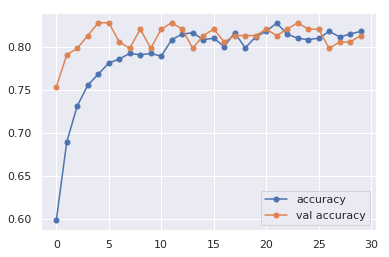

In [27]:
batch_size=32

model=Sequential()

model.add(Dense(50, input_shape=(trainX.shape[1],),activation='relu') )
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(50) )
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(1, input_shape=(trainX.shape[1],),activation='sigmoid') ) 
# initiate RMSprop optimizer
opt = RMSprop(lr=0.01, decay=1e-5)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

history=model.fit(trainX.values,trainY.values,epochs=30,
                  validation_data=( valX.values, valY.values ), batch_size=batch_size,verbose=1)

#畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回到頂部](#%E6%9C%AC%E7%AD%86%E8%A8%98%E6%8B%BF%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E8%B3%87%E6%96%99%E9%9B%86%E4%BE%86%E7%B7%B4%E7%BF%92%E5%BB%BA%E6%A8%A1%E3%80%82)

---

In [28]:
## 輸出成csv, 提交至Kaggle:
# subm=np.vstack( (dfTest["PassengerId"].values,testY) ).T
# subm=pd.DataFrame(subm,columns=["PassengerId","Survived"])
# subm.to_csv("~/Dropbox/Learning/submissionLogistic.csv",index=None)